### 라이브러리 임포트

In [1]:
from typing import *
import numpy as np
from numpy import ndarray

In [2]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
%matplotlib inline

from copy import deepcopy
from collections import deque

In [3]:
from scipy.special import logsumexp

### 활성화 함수

In [4]:
def sigmoid(x: ndarray):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x: ndarray):
    return sigmoid(x) * (1 - sigmoid(x))


def tanh(x: ndarray):
    return np.tanh(x)


def dtanh(x: ndarray):
    return 1 - np.tanh(x) * np.tanh(x)


def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))


def batch_softmax(input_array: ndarray):
    out = []
    for row in input_array:
        out.append(softmax(row, axis=1))
    return np.stack(out)

## 자동 미분

In [5]:
a = np.array([3,3])
print("Addition using '__add__': ", a.__add__(4))
print("Addition using '+': ", a + 4)

Addition using '__add__':  [7 7]
Addition using '+':  [7 7]


In [6]:
Numberable = Union[float, int]

def ensure_number(num: Numberable):
  if isinstance(num, NumberWithGrad):
    return num
  else:
    return NumberWithGrad(num)

class NumberWithGrad(object):

  def __init__(self,
               num: Numberable,
               depends_on: List[Numberable] = None,
               creation_op: str = ''):
    self.num = num
    self.grad = None
    self.depends_on = depends_on or []
    self.creation_op = creation_op

  def __add__(self,
              other: Numberable):

    return NumberWithGrad(self.num + ensure_number(other).num,
                          depends_on = [self, ensure_number(other)],
                          creation_op = 'add')
  def __mul__(self,
              other: Numberable = None):
    
    return NumberWithGrad(self.num * ensure_number(other).num,
                          depends_on = [self, ensure_number(other)],
                          creation_op = 'mul')
    
  def backward(self, backward_grad: Numberable = None) -> None:
    if backward_grad is None:   # backward가 처음 호출됨
      self.grad = 1
    else:
      # 이 부분에서 기울기가 누적됨
      # 기울기 정보가 아직 없다면 backward_grad로 설정
      if self.grad is None:
        self.grad = backward_grad
      # 기울기 정보가 있다면 기존 기울기값에 backward_grad를 더함
      else:
        self.grad += backward_grad

    if self.creation_op == 'add':
      # self.grad를 역방향으로 전달함
      # 둘 중 어느 요소를 증가시켜도 출력이 같은 값만큼 증가함
      self.depends_on[0].backward(self.grad)
      self.depends_on[1].backward(self.grad)

    if self.creation_op == 'mul':
      
      # 첫 번째 요소에 대한 미분 계산
      new = self.depends_on[1] * self.grad
      # 이 요소에 대한 미분을 역방향으로 전달
      self.depends_on[0].backward(new.num)

      # 두 번째 요소에 대한 미분 계산
      new = self.depends_on[0] * self.grad
      # 이 요소에 대한 미분을 역방향으로 전달
      self.depends_on[1].backward(new.num)

In [7]:
a = NumberWithGrad(3)

b = a * 4
c = b + 5

In [8]:
c.backward()

In [9]:
print(a.grad)
print(b.grad)

4
1


자동 미분 수행 과정

In [10]:
a = NumberWithGrad(3)

b = a * 4
c = b + 3
d = c * (a + 2)

"""
d = (4a + 3) x (a + 2)
  = 4a²+ 11a + 6

미적분 시, 도함수
  = 8a + 11
a = 3 일 때, 미분은 8 x 3 + 11 = 35가 된다.
"""

'\nd = (4a + 3) x (a + 2)\n  = 4a²+ 11a + 6\n\n미적분 시, 도함수\n  = 8a + 11\na = 3 일 때, 미분은 8 x 3 + 11 = 35가 된다.\n'

In [11]:
def forward(num: int):
  b = num * 4
  c = b + 3
  return c * (num + 2)

print(round((forward(3.01) - forward(2.99)) / 0.02, 3))

35.0


In [12]:
a = NumberWithGrad(3)

b = a * 4
c = b + 3
d = (a + 2)
e = c * d
e.backward()

print(a.grad)

35


#### 자동 미분의 원리
자동 미분의 목적은 연산 대신 숫자, ndarray, Tensor 등 데이터 객체 자신이 해석의 대상이 되는 것이다.

모든 자동 미분 기법의 공통적인 특징은 다음과 같다.

- 연산 대상이 되는 실제 데이터를 감싼 래퍼 클래스를 만든다. 우리가 만든 프레임워크에서는 float와 int를 감싸는 NumberWithGrad 클래스를 만들었다. 파이토치에서도 비슷한 역할을 하는 Tensor 클래스가 있다.

- 덧셈, 곱셈, 행렬곱 등의 연산이 래퍼 클래스를 객체를 반환하도록 재정의한다. 앞서 본 예제에서도 NumberWithGrad 객체끼리의 연산이나 NumberWithGrad와 float, int의 연산 모두 NumberWithGrad 객체를 반환하도록 연산을 재정의했다.

- NumberWithGrad 클래스는 순방향 계산 결과에 따라 기울기 계산에 필요한 정보를 포함해야 한다. 앞 예제에서는 인스턴스 변수 creation_op에 해당 객체가 생성된 연산 정보를 담았다.

- 역방향 계산 과정에서 기울기는 기반 데이터 타입으로 전달된다. 이 예제에서는 기울기가 NumberWithGrad 타입이 아니라 float와 int 타입이다.

- 이번 절 처음에서 언급했듯이 자동 미분으로 순방향 계산 과정의 중간 결과를 재사용할 수 있다. 앞 예제에서도 a를 문제없이 두 번 사용했다. 다음 그 코드가 핵심 원리다.

```
if self.grad is None:
  self.grad = backward_grad
else:
  self.grad += backward_grad
```

- backward_grad로 기울기를 처음 전달받으면 이 값으로 지정된 기울기 값을 초기화하고, 기울기를 전달 받은 적이 있다면 기존 값에 전달받은 값을 더한다. NumberWithGrad 객체는 모델 안에서 재사용된 값의 기울기를 누적한다.

#### 순환 신경망 구현을 위한 첫 번째 클래스: RNNLayer

1. data[:, 0, :]로 시작하는 두 번째 축에 늘어선 2차원 배열을 하나 선택한다. 이렇게 선택된 배열의 모양은 (batch_size, num_features)가 된다.

2. RNNLayer 객체의 '내부 상태'를 (batch_size, hidden_size) 모양으로 초기화한다. 이 상태는 연속열이 한 요소씩 입력되는 과정에서 지속적으로 수정된다. 그러므로 이 ndarray 객체는 이 층이 현재 시각까지 입력받은 데이터에 대한 '누적된 정보'를 나타낸다.

3. 1과 2에 나온 2개의 ndarray 객체로 첫 번째 시각에 대한 순방향 계산을 수행한다. 우리가 만들 RNNLayer는 일반적인 Dense층처럼 입력과 출력의 모양이 다르게 설계된다. 따라서 출력의 모양은 (batch_size, num_outputs)가 된다. 관찰을 하나씩 입력하며 신경망 안에 들어 있는 표현을 수정한다. 이때 RNNLayer도 각 시각마다 (batch_size, hidden_size) 모양의 ndarray 객체를 출력한다.

4. 데이터의 두 번째 축에서 그 다음 2차원 배열(data[:, 1, :])을 선택한다.

5. 첫 번째 시각에서 출력된 표현과 데이터로 두 번째 시각의 순방향 계산을 수행하고 그 결과로 (batch_size, num_outputs) 모양의 출력을 내놓는다. 또한 (batch_size, hidden_size) 모양의 표현도 수정된다.

6. sequence_length번 동안 이 과정을 반복한다. 그 다음 출력값을 모아 (batch_size, sequence_length, num_outputs) 모양으로 합친다.

#### 순환 신경망 구현을 위한 두 번째 클래스: RNNNode
앞의 동작 내용에 따르면 RNNNode 클래스는 다음과 같은 입출력을 갖는 forward 메서드를 갖춰야 한다.

- 입력: 2개의 ndarray 객체
  - 모양이 [batch_size, num_features]인 신경망의 입력
  - 모양이 [batch_size, hidden_size]인 해당 시각의 표현

- 출력: 2개의 ndarray 객체
  - 모양이 [batch_size, num_outputs]인 해당 시각의 출력
  - 모양이 [batch_size, hidden_size]인 해당 시각에 수정된 표현

#### 두 클래스 결합하기

RNNLayer 객체는 RNNNode 객체의 리스트를 내부에 포함하며 다음과 같은 입출력을 갖는 forward 메서드를 갖춰야 한다.

- 입력: 모양이 [batch_size, sequence_length, num_features]인 관찰의 연속열로 구성된 배치
- 출력: 모양이 [batch_size, sequence_length, num_outputs]인 층의 출력

#### 역방향 계산

순환 신경망의 역전파 알고리즘은 흔히 BPTT(Backpropagation through time)라는 별도의 알고리즘으로 취급된다. 순방향 계산 과정에서 데이터가 흐르는 방식을 잘 기억하면, 같은 방식으로 역뱡향 계산 과정도 설명할 수 있다. 입력이 흘렀던 방식의 정확히 반대 방향으로 기울기를 전달하면 된다.

[순방향 계산 과정]

1. 각 모양이 (features_size, sequence_length)인 관찰로 구성된 배치로 시작한다.
2. 이 입력을 sequence_length개의 요소로 분할한 다음, 한 번에 하나씩 신경망에 입력한다.
3. 각 요소가 모든 층을 통과하면 output_size 차원의 출력으로 변환된다.
4. 이와 같은 시점에 층의 내부 상태가 다음 시각의 입력으로 전달된다.
5. 1~4의 과정을 sequence_length시각 동안 반복하면 전체 (output_size, sequence_length) 크기의 출력이 나온다.

<br/>

[역전파 계산 과정]

1. 모양이 [output_size, sequence_length]인 기울기로 시작한다. 이 기울기는 출력(크기가 [output_size, sequence_length])의 각 요소가 해당 배치의 손실값에 미친 영향을 의미한다.
2. 기울기를 sequence_length개의 요소로 분할한 다음, 한 번에 하나씩 신경망의 출력층에 입력하여 층을 거슬러 올라간다.
3. 각 요소의 기울기를 모든 층에 통과시킨다.
4. 마찬가지로 각 층은 해당 시각의 내부 상태에 대한 손실의 기울기를 자신의 이전 시각의 계산으로 전달한다.
5. 1~4의 과정을 sequence_length시각 동안 반복해서 신경망 맨 앞까지 기울기를 전달한다. 순방향 신경망처럼 이 과정에서 각 가중치에 대한 손실의 기울기가 계산된다.

### 헬퍼함수

In [13]:
def assert_same_shape(output: ndarray,
                      output_grad: ndarray):
  assert output.shape == output_grad.shape, \
  f"""
  두 ndarray의 모양이 같아야 하는데,
  첫 번째 ndarray의 모양은 {tuple(output_grad.shape)}이고,
  두 번째 ndarray의 모양은 {tuple(output.shape)}이다.
  """
  return None

### RNNOptimizer 클래스

In [14]:
class RNNOptimizer(object):
  def __init__(self,
               lr: float = 0.01,
               gradient_clipping: bool = True) -> None:
    self.lr = lr
    self.gradient_clipping = gradient_clipping
    self.first = True

  def step(self)-> None:
    
    for layer in self.model.layers:
      for key in layer.params.keys():

        if self.gradient_clipping:
          np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])

        self._update_rule(param = layer.params[key]['value'],
                          grad = layer.params[key]['deriv'])
        
  def _update_rule(self, **kwargs) -> None:
    raise NotImplementedError()

### SGD, AdaGrad 클래스

In [15]:
class SGD(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                 gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)

    def _update_rule(self, **kwargs) -> None:

        update = self.lr*kwargs['grad']
        kwargs['param'] -= update

In [16]:
class AdaGrad(RNNOptimizer):
    def __init__(self,
                 lr: float = 0.01,
                gradient_clipping: bool = True) -> None:
        super().__init__(lr, gradient_clipping)
        self.eps = 1e-7

    def step(self) -> None:
        if self.first:
            self.sum_squares = {}
            for i, layer in enumerate(self.model.layers):
                self.sum_squares[i] = {}
                for key in layer.params.keys():
                    self.sum_squares[i][key] = np.zeros_like(layer.params[key]['value'])
            
            self.first = False

        for i, layer in enumerate(self.model.layers):
            for key in layer.params.keys():
                
                if self.gradient_clipping:
                    np.clip(layer.params[key]['deriv'], -2, 2, layer.params[key]['deriv'])
                
                self._update_rule(param=layer.params[key]['value'],
                                  grad=layer.params[key]['deriv'],
                                  sum_square=self.sum_squares[i][key])

    def _update_rule(self, **kwargs) -> None:

            # 이전 기울기의 제곱의 합을 계산
            kwargs['sum_square'] += (self.eps +
                                     np.power(kwargs['grad'], 2))

            # 이전 5개 기울기의 제곱의 합으로 학습률을 수정
            lr = np.divide(self.lr, np.sqrt(kwargs['sum_square']))

            # 수정된 학습률을 적용
            kwargs['param'] -= lr * kwargs['grad']

### 손실함수

In [17]:
class Loss(object):

    def __init__(self):
        pass

    def forward(self,
                prediction: ndarray,
                target: ndarray) -> float:

        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        self.output = self._output()

        return self.output
    
    def backward(self) -> ndarray:

        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        raise NotImplementedError()

        
class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float=1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output(self) -> float:

        out = []
        for row in self.prediction:
            out.append(softmax(row, axis=1))
        softmax_preds = np.stack(out)

        # 안정적인 계산을 위해 소프트맥스의 출력을 제한
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # 손실을 실제로 계산
        softmax_cross_entropy_loss = -1.0 * self.target * np.log(self.softmax_preds) - \
            (1.0 - self.target) * np.log(1 - self.softmax_preds)

        return np.sum(softmax_cross_entropy_loss)

    def _input_grad(self) -> np.ndarray:

        return self.softmax_preds - self.target

## RNN 코드

1. RNN에서도 데이터는 각 층을 통과해야 한다. 각 층은 순방향 계산 과정에서 출력을 다음 층으로 전달하고, 역방향 계산 과정에서는 기울기를 이전 층으로 전달한다. 그러므로 이전의 NeuralNetwork 클래스와 같은 역할을 맡은 클래스는 layers라는 이름의 RNNLayer 객체의 리스트를 통해 다음과 같은 코드로 순방향 계산을 구현한다.

```
def forward(self, x_batch: ndarray) -> ndarray:

  assert_dim(ndarray, 3)
  
  x_out = x_batch
  for layer in self.layers:
    x_out = layer.forward(x_out)
  
  return x_out
```

2. 손실을 계산하는 과정을 전과 같다. 신경망의 마지막 층에서 출력된 ndarray 객체의 값을 y_batch의 목표값과 비교한 다음, 이를 바탕으로 손실값을 계산한다. 그리고 입력에 대한 손실의 기울기를 계산하는데, 이 기울기는 출력과 모양이 같은 ndarray다. 이러려면 소프트맥스 함수가 [batch_size, sequence_length, feature_size] 모양의 ndarray를 다룰 수 있도록 수정해야 함.

3. Trainer 클래스는 그대로 유지된다. 학습 데이터를 순화하며 입력 데이터와 출력 데이터의 배치를 선택하고 순서대로 모델에 배치를 입력해 손실값을 계산한 다음, 이 값을 통해 학습이 잘 진해오디는지 확인하고 가중치를 수정한다.

4. Optimizer 클래스도 그대로 유지된다. 매 시각마다 params와 param_grads에서 필요한 값을 찾는 방법이 달라지겠지만, '수정규칙'(_updatte_rule 메서드에 표현된)은 그대로 사용한다.

#### RNNLayer 클래스

RNNLayer는 새로운 데이터가 끊임없이 입력되며 이 정보를 반영해 지속적으로 매 시간마다 수정되는 '내부 상태'를 유지해야한다.
- RNNLayer는 RNNNode 객체의 리스트를 속성으로 가지며, 이 RNNNode는 연속열의 요소가 하나씩 차례대로 통과한다. 따라서 RNNNode는 연속열의 요소와 자신을 포함하는 층의 내부상태를 입력받는다.
- 그리고 현재 시각에 대한 해당 층의 출력을 내보내고 내부 상태를 수정한다.

<br/>

#### 초기화하기
RNNLayer 객체는 초기화를 위해 다음과 같은 정보를 받는다.

- int 타입 hidden_size
- int 타입 output_size
- ndarray 타입 start_H(모양은 (1, hidden_size)) 이 층의 내부 상태가 저장된다.

초기화할 때 self.first = True플래그를 설정한다. 이 플래그가 참이면 forward 메서드가 데이터로 전달받은 ndarray 객체를 \_init_params 메서드에 전달해 파라미터를 초기화한 다음, 플래그를 거짓(self.first = False)로 설정한다.

#### forward 메서드

- forward 메서드의 대부분은 모양이 (batch_size, sequence_length, feature_size)인 ndarray 객체 x_seq_in을 입력 받고 이 데이터를 RNNNode 객체들에 순서대로 통과시키는 코드다. 다음 코드에서 self.nodes는 이 층이 가진 RNNNode 객체의 리스트이며, H_in은 이 층의 내부 상태다.

```
sequence_length = x_seq_in.shape[1]

x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))

for t in range(sequence_length):
  x_in = x_seq_in[:, t, :]
  y_out, H_in = self.nodes[t].forward(x_in, H_in, self.params)
  x_seq_out[:, t, :] = y_out
```

- RNNLayer의 내부 상태 H_in은 일반적으로 하나의 벡터로 표현된다. 그러나 RNNNode의 ㅇ녀산을 수행하려면 내부 상태가(batch_size, hidden_size) 모양의 ndarray여야 한다. 그러므로 순방향 계산을 시작하기 전에 다음과 같이 내부 상태를 복사한다.

```
batch_size = x_seq_in.shape[0]

H_in = np.copy(self.start_H)

H_in = np.repeat(H_in, batch_size, axis = 0)
```

- 순방향 계산이 끝난 후에는 각 관찰에 대해 계산된 내부 상태를 평균 내고, 이를 층의 새로운 내부 상태로 삼는다.

```
self.start_H = H_in.mean(axis = 0, keepdims = True)
```

- 위 코드에서 RNNNode의 forward 메서드가 다음과 같은 모양으 ㅣ배열 2개를 입력받는다는 것을 알게 되었다.
  - (batch_size, feature_size)
  - (batch_size, hidden_size)

- 메서드가 반환하는 배열의 모양은 다음과 같다.
  - (batch_size, output_size)
  - (batch_size, hidden_size)

#### backward 메서드

- forward 메서드는 x_seq_out을 반환하므로 backward 메서드는 x_seq_out과 모양이 같은 기울기인 x_seq_grad를 인자로 받는다. forward 메서드와는 반대 방향으로 이 기울기를 RNNNode 객체에 통과시킨다. 그리고 그 결과로 모양이 (batch_size, sequence_length, self.feature_size)인 배열 x_seq_in_grad를 전체 층에 대한 기울기로 반환한다.

```
h_in_grad = np.zeros((batch_size, self.hidden_size))

sequence_length = x_seq_out_grad.shape[1]

x_seq_in_grad = np.zeros((batch_size, sequence_length, self.feature_size))

for t in reversed(range(sequence_length)):
  x_out_grad = x_seq_out_grad[:, t, :]
  grad_out, h_in_grad = self.nodes[t].backward(x_out_grad, h_in_grad, self.params)

x_seq_in_grad[:, t, :] = grad_out
```

- 위 코드로 볼 때, RNNNode 클래스에도 backward 메서드가 있어야 한다. 이 메서드는 forward와 반대로 동작하므로 인자와 반환값이 모양이 다음과 같이 서로 바뀐다.
  - (batch_size, output_size)
  - (batch_size, hidden_size)

- 반환값의 모양은 다음과 같다.
  - (batch_size, feature_size)
  - (batch_size, hidden_size)

#### RNNNode 클래스의 공통요소

- 바닐라 RNN(vanilla RNN): 기본적인 RNN 구현 방법
- 게이트 순환 유닛(gated recurrent unit_GRU): 바닐라 RNN과 다른 RNNNode를 구현하는 방법

- RNN의 모든 층은 순방향으로 데이터가 흘러가는 패텅이 동일하며, 매 시각마다 내부 상태를 수정한다. 차이점은 '노드'가 동작하는 내부의 세부 사항에 국한된다.
- RNNLayer 대신 GRULayer를 구현하면 다음 코드를 순방향 계산의 핵심 부분에 그대로 사용할 수 있다.

```
sequence_length = x_seq_in.shape[1]

x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))

for t in range(sequence_length):
  x_in = x_seq_in[:, t, :]
  y_out, H_in = self.nodes[t].forward(x_in, H_in, self.params)
  x_seq_ut[:, t, :] = y_out
```
구현상 차이점은 단지 self.nodes 안에 든 '노드'들이 RNNNode가 아닌 GRUNode 객체라는 점이다. backward 메서드의 코드도 동일하다.

- RNN의 변종 중 가장 유명한 LSTM(Long Short-Term Memory) 역시 마찬가지다. 바닐라 RNN과 LSTM의 차이점은 LSTMLayer 객체가 지속적으로 기억하고 입력되는 데이터에 따라 수정하는 값이 기존의 '내부 상태'만 있던 것에서 '셀 상태'까지 한가지 추가되는 점이다. 이 차이점 때문에 LSTMLayer는 RNNLayer와 구현 코드가 약간 다르다. 이를테면 LSTMLayer는 시간의 흐름에 따른 층의 상태를 저장하는 데 다음과 같은 2개의 ndarray 객체를 사용한다.

  - ndarray 타입 start_H(모양은 (1, hidden_size)) 층의 내부 상태를 나타냄.
  - ndarray 타입 start_C(모양은 (1, cell_size)) 층의 셀 상태를 나타냄.

- 그러므로 LSTMNode 객체도 내부 상태와 셀 상태를 모두 입력으로 받는다. 따라서 순방향 계산 코드는 다음과 같다.

```
y_out, H_in, C_in = self.nodes[t].forward(x_in, H_in, C_in, self.params)
```

- 역방향 계산 코드는 다음과 같다.

```
grad_out, h_in_grad, c_in_grad = self.nodes[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)
```

#### 바닐라 RNNNode 클래스

- RNN은 순차 데이터의 요소를 한 번에 1개씩 입력받는다. RNN이 하는 일은 새로 입력된 현재 시각의 특징과 지금까지 입력받은 정보의 누적, 이 두 가지 데이터를 결합해서 현재 시각의 목표값을 예측함과 동시에 누적된 정보를 최신 상태로 수정하는 것이다.

- 이를 위해 RNN을 어떻게 구현해야 하는가에 대한 힌트를 일반적인 신경망에서 얻을 수 있다. 순방향 신경망의 각 층은 이전 층에서 '학습된 특징'을 전달받는다. 학습된 특징이란 최초의 특징 중 유용했던 것들의 조합이다. 층에 입력된 특징은 가중치 행렬과 곱해져서 다시 새롱누 특징을 조합한다. 그리고 그 결과값을 안정화하고 정규화하기 위해 '편향'을 더한 다음, 활성화 함수에 통과시킨다.

- RNN에서 최신 정보로 수정된 내부 상태의 값은 입력과 이전 내부 상태값의 조합이다. 순방향 신경망에서 새로운 특징을 조합하는 과정과 같다면 계산 과정은 다음과 같다.
  1. 먼저 입력과 내부 상태값을 연결한다. 그 다음 이 값과 가중치 행렬을 곱하고, 편향을 더한 다음, 활성화 함수 Tanh을 거친다. 그리고 결과값을 새로운 내부 상태로 삼는다.
  2. 그 다음에는 새로 수정된 내부 상태를 가중치와 곱해 우리가 우너하는 출력의 모양으로 만든다. 예를 들어 매 시각마다 단일한 연속값으로 된 예측값을 원한다면(hidden_size, 1) 모양의 가중치 행렬을 곱하면 된다.

그 결과 내부 상태는 입력과 이전 시각의 내부 상태로부터 결정되며, 출력은 새로운 내부 상태가 전결합층을 거친 결과가 된다.

순방향 계산

In [18]:
def forward(self,
            x_in: ndarray,
            H_in: ndarray,
            params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
  """
  param x: 모양이 (batch_size, vocab_size)인 넘파이 배열
  param H_prev: 모양이 (bathc_size, hidden_size)인 넘파이 배열
  return self.x_out: 모양이 (batch_size, vocab_size)인 넘파이 배열
  return self.H: 모양이 (batch_size, hidden_size)인 넘파이 배열
  """
  self.X_in = x_in
  self.H_in = H_in

  self.Z = np.column_stack((x_in, H_in))

  self.H_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']

  self.H_out = tanh(self.H_int)

  self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']

  return self.X_out, self.H_out

역방향 계산

RNNNode의 출력에 대한 소신의 기울기가 주어졌을 때 이 기울기에 따라 입력에 대한 손실의 기울기를 계산하는 과정이다.

In [19]:
def backward(self,
             X_out_grad: ndarray,
             H_out_grad: ndarray,
             params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
  """
  param x_out_grad: 모양이 (batch_size, vocab_size)인 넘파이 배열
  param h_out_grad: 모양이 (batch_size, hidden_size)인 넘파이 배열
  param RNN_Params: RNN_Params 객체
  return x_in_grad: 모양이 (batch_size, vocab_size)인 넘파이 배열
  return h_in_grad: 모양이 (batch_size, hidden_size)인 넘파이 배열
  """

  assert_same_shape(X_out_grad, self.X_out)
  assert_same_shape(H_out_grad, self.H_out)

  params_dict['B_v']['deriv'] += X_out_grad.sum(axis = 0)
  params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

  dh = np.dot(X_out_grad, params_dict['W_v']['value'].T)
  dh += H_out_grad

  dH_int = dh * dtanh(self.H_int)

  params_dict['B_f']['deriv'] += dH_int.sum(axis = 0)
  params_dict['W_f']['deriv'] += np.dot(self.Z.T, dH_int)

  dz = np.dot(dH_int, params_dict['W_f']['value'].T)

  X_in_grad = dz[:, :self.X_in.shape[1]]
  H_in_grad = dz[:, self.X_in.shape[1]:]

  assert_same_shape(X_out_grad, self.X_out)
  assert_same_shape(H_out_grad, self.H_out)

  return X_in_grad, H_in_grad

RNNNode

In [20]:
class RNNNode(object):

  def __init__(self):
    pass

  def forward(self,
            x_in: ndarray,
            H_in: ndarray,
            params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
    """
    param x: 모양이 (batch_size, vocab_size)인 넘파이 배열
    param H_prev: 모양이 (bathc_size, hidden_size)인 넘파이 배열
    return self.x_out: 모양이 (batch_size, vocab_size)인 넘파이 배열
    return self.H: 모양이 (batch_size, hidden_size)인 넘파이 배열
    """
    self.X_in = x_in
    self.H_in = H_in

    self.Z = np.column_stack((x_in, H_in))

    self.H_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']

    self.H_out = tanh(self.H_int)

    self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']

    return self.X_out, self.H_out

  def backward(self,
             X_out_grad: ndarray,
             H_out_grad: ndarray,
             params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
    """
    param x_out_grad: 모양이 (batch_size, vocab_size)인 넘파이 배열
    param h_out_grad: 모양이 (batch_size, hidden_size)인 넘파이 배열
    param RNN_Params: RNN_Params 객체
    return x_in_grad: 모양이 (batch_size, vocab_size)인 넘파이 배열
    return h_in_grad: 모양이 (batch_size, hidden_size)인 넘파이 배열
    """

    assert_same_shape(X_out_grad, self.X_out)
    assert_same_shape(H_out_grad, self.H_out)

    params_dict['B_v']['deriv'] += X_out_grad.sum(axis = 0)
    params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

    dh = np.dot(X_out_grad, params_dict['W_v']['value'].T)
    dh += H_out_grad

    dH_int = dh * dtanh(self.H_int)

    params_dict['B_f']['deriv'] += dH_int.sum(axis = 0)
    params_dict['W_f']['deriv'] += np.dot(self.Z.T, dH_int)

    dz = np.dot(dH_int, params_dict['W_f']['value'].T)

    X_in_grad = dz[:, :self.X_in.shape[1]]
    H_in_grad = dz[:, self.X_in.shape[1]:]

    assert_same_shape(X_out_grad, self.X_out)
    assert_same_shape(H_out_grad, self.H_out)

    return X_in_grad, H_in_grad

RNNLayer

In [21]:
class RNNLayer(object):

  def __init__(self,
               hidden_size: int,
               output_size: int,
               weight_scale: float = None):
    """
    param sequence_length: int - 연속열의 길이
    param vocab_size: int - 사용되는 글자의 가짓수
    param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수
    param learning_rate: float - 학습률
    """

    self.hidden_size = hidden_size
    self.output_size = output_size
    self.weight_scale = weight_scale
    self.start_H = np.zeros((1, hidden_size))
    self.first = True

  def _init_params(self, 
                   input_: ndarray):
    
    self.vocab_size = input_.shape[2]

    if not self.weight_scale:
      self.weight_scale = 2 / (self.vocab_size + self.output_size)

    self.params = {}
    self.params['W_f']  = {}
    self.params['B_f']  = {}
    self.params['W_v']  = {}
    self.params['B_v']  = {}

    self.params['W_f']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (self.hidden_size + self.vocab_size, self.hidden_size))
    self.params['B_f']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (1, self.hidden_size))
    self.params['W_v']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (self.hidden_size, self.output_size))
    self.params['B_v']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (1, self.output_size))
    
    self.params['W_f']['deriv'] = np.zeros_like(self.params['W_f']['value'])
    self.params['B_f']['deriv'] = np.zeros_like(self.params['B_f']['value'])
    self.params['W_v']['deriv'] = np.zeros_like(self.params['W_v']['value'])
    self.params['B_v']['deriv'] = np.zeros_like(self.params['B_v']['value'])

    self.cells = [RNNNode() for x in range(input_.shape[1])]

  def _clear_gradients(self):
    for key in self.params.keys():
      self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])

  def forward(self, x_seq_in: ndarray):
    """
    param x_seq_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    return x_seq_out: 모양이 (batch_size, sequence_length, output_size)인 넘파이 배열
    """
    if self.first:
      self._init_params(x_seq_in)
      self.first = False

    batch_size = x_seq_in.shape[0]

    H_in = np.copy(self.start_H)

    H_in = np.repeat(H_in, batch_size, axis = 0)

    sequence_length = x_seq_in.shape[1]

    x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))

    for t in range(sequence_length):
      x_in = x_seq_in[:, t, :]
      y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      x_seq_out[:, t, :] = y_out

    self.start_H = H_in.mean(axis = 0, keepdims = True)

    return x_seq_out

  def backward(self, x_seq_out_grad: ndarray):
    """
    param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    return loss_grad_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """
    batch_size = x_seq_out_grad.shape[0]

    h_in_grad = np.zeros((batch_size, self.hidden_size))

    sequence_length = x_seq_out_grad.shape[1]

    x_seq_in_grad = np.zeros((batch_size, sequence_length, self.vocab_size))

    for t in reversed(range(sequence_length)):
      x_out_grad = x_seq_out_grad[:, t, :]
      grad_out, h_in_grad = self.cells[t].backward(x_out_grad, h_in_grad, self.params)

      x_seq_in_grad[:, t, :] = grad_out

    return x_seq_in_grad

RNNModel

In [22]:
class RNNModel(object):
  """
  이 클래스는 입력과 목표값으로 신경망을 실제로 학습하며 손실을 계산한다.
  """
  def __init__(self,
               layers: List[RNNLayer],
               sequence_length: int,
               vocab_size: int,
               loss: Loss):
    """
    param num_layers: int - 신경망의 층 수
    param sequence_length: int - 입력받을 연속열의 길이
    param vocab_size: int - 사용되는 글자의 가짓수
    param hidden_size: int - 각 층의 은닉 뉴런 수
    """
    self.layers = layers
    self.vocab_size = vocab_size
    self.sequence_length = sequence_length
    self.loss = loss
    for layer in self.layers:
      setattr(layer, 'sequence_length', sequence_length)

  def forward(self, x_batch: ndarray):
    """
    param inputs: list of integers - 신경망에 입력되는 연속열,
    연속열의 각 글자에 해당하는 정수의 리스트 형태다.
    returns x_batch_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """
    for layer in self.layers:
      x_batch = layer.forward(x_batch)

    return x_batch

  def backward(self, loss_grad: ndarray):
    """
    param loss_grad: 모양이(batch_size, sequence_length, vocab_size)인 넘파이 배열
    return loss: float, 평균제곱오차 값
    """
    for layer in reversed(self.layers):
      loss_grad = layer.backward(loss_grad)
    
    return loss_grad

  def single_step(self,
                  x_batch: ndarray,
                  y_batch: ndarray):
    """
    여기서 수행되는 과정
    1. 순방향 계산, 소프트맥스 함수 통과
    2. 손실 및 손실의 기울기 계산
    3. 역방향 계산
    4. 파라미터 수정
    param inputs: 길이가 sequence_length인 리스트, 입력되는 연속열의 각 글자에 해당하는 정수의 리스트다.
    param targets: 길이가 sequence_length인 리스트, 목표값인 글자에 해당하는 정수의 리스트다.
    """
    x_batch_out = self.forward(x_batch)

    loss = self.loss.forward(x_batch_out, y_batch)

    loss_grad = self.loss.backward()

    for layer in self.layers:
      layer._clear_gradients()

    self.backward(loss_grad)
    return loss

RNNTrainer

In [23]:
class RNNTrainer:
  """
  텍스트 파일과 모델을 전달받아 이어지는 글자를 예측한다.
  """
  def __init__(self,
               text_file: str,
               model: RNNModel,
               optim: RNNOptimizer,
               batch_size: int = 32):
    self.data = open(text_file, 'r').read()
    self.model = model
    self.chars = list(set(self.data))
    self.vocab_size = len(self.chars)
    self.char_to_idx = {ch:i for i, ch in enumerate(self.chars)}
    self.idx_to_char = {i:ch for i, ch in enumerate(self.chars)}
    self.sequence_length = self.model.sequence_length
    self.batch_size = batch_size
    self.optim = optim
    setattr(self.optim, 'model', self.model)

  def _generate_inputs_targets(self,
                               start_pos: int):
    inputs_indices = np.zeros((self.batch_size, self.sequence_length), dtype = int)
    targets_indices = np.zeros((self.batch_size, self.sequence_length), dtype = int)

    for i in range(self.batch_size):
      inputs_indices[i, :] = np.array([self.char_to_idx[ch] for ch in self.data[start_pos + i: start_pos + self.sequence_length + i]])
      targets_indices[i, :] = np.array([self.char_to_idx[ch] for ch in self.data[start_pos + 1 + i: start_pos + self.sequence_length + 1 + i]])

    return inputs_indices, targets_indices

  def _generate_one_hot_array(self, indices: ndarray):
    """
    param indices: 모양이 (batch_size, sequence_length)인 넘파이 배열
    return batch: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """
    batch = []
    for seq in indices:
      one_hot_sequence = np.zeros((self.sequence_length, self.vocab_size))

      for i in range(self.sequence_length):
        one_hot_sequence[i, seq[i]] = 1.0

      batch.append(one_hot_sequence)

    return np.stack(batch)

  def sample_output(self,
                    input_char: int,
                    sample_length: int):
    """
    현재 학습된 모델로 한 글자씩 출력을 생성한다.
    param input_char: int - 연속열을 시작하는 글자의 인덱스에 해당하는 정수
    param sample_length: int - 생성할 연속열의 길이
    return txt: string - 길이가 sample_length이며 모델을 통해 생성한 문자열
    """
    indices = []
    
    sample_model = deepcopy(self.model)

    for i in range(sample_length):
      input_char_batch = np.zeros((1, 1, self.vocab_size))
      input_char_batch[0, 0, input_char] = 1.0

      x_batch_out = sample_model.forward(input_char_batch)
      x_softmax = batch_softmax(x_batch_out)
      
      input_char = np.random.choice(range(self.vocab_size), p = x_softmax.ravel())
      indices.append(input_char)

    txt = ''.join(self.idx_to_char[idx] for idx in indices)

    return txt

  def train(self,
            num_iterations: int,
            sample_every: int = 100):
    """
    '글자 생성기'를 학습
    각 반복마다 신경망에 크기가 1인 배치가 입력된다.
    num_iterations회 반복한다. 매 반복마다 현재 학습된 모델로 생성한 텍스트가 출력된다.
    """
    plot_iter = np.zeros((0))
    plot_loss = np.zeros((0))

    num_iter = 0
    start_pos = 0

    moving_average = deque(maxlen = 100)
    while num_iter < num_iterations:

      if start_pos + self.sequence_length + self.batch_size + 1 > len(self.data):
        start_pos = 0

      # 모델 수정
      inputs_indices, targets_indices = self._generate_inputs_targets(start_pos)

      inputs_batch, targets_batch = self._generate_one_hot_array(inputs_indices), self._generate_one_hot_array(targets_indices)

      loss = self.model.single_step(inputs_batch, targets_batch)
      self.optim.step()

      moving_average.append(loss)
      ma_loss = np.mean(moving_average)

      start_pos += self.batch_size

      plot_iter = np.append(plot_iter, [num_iter])
      plot_loss = np.append(plot_loss, [ma_loss])

      if num_iter % 100 == 0:
        plt.plot(plot_iter, plot_loss)
        display.clear_output(wait = True)
        plt.show()

        sample_text = self.sample_output(self.char_to_idx[self.data[start_pos]], 200)

        print(sample_text)

      num_iter += 1

In [24]:
%cd /content/drive/MyDrive/colab/deep_learning_basic/처음_시작하는_딥러닝

/content/drive/MyDrive/colab/deep_learning_basic/처음_시작하는_딥러닝


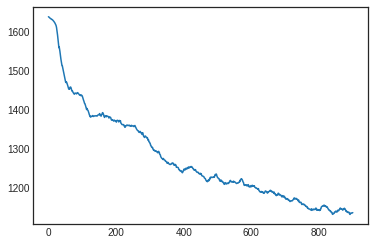

 Soir ches fitr plin
'
qo remOwa
AnqWg, Id cher thot aithas WoGs mlouthecnA!r wemns
as, ba wile whanf, fourQveaUht Gihn wed bges ind foSlo gothonds,
zPtRAerath
yame th ap s norrestcir maceac

orngin m


In [25]:
layers = [RNNLayer(hidden_size = 256, output_size=62)]
mod = RNNModel(layers= layers,
               vocab_size = 62,
               sequence_length = 10,
               loss = SoftmaxCrossEntropy())

optim = SGD(lr = 0.001, gradient_clipping= True)
trainer = RNNTrainer('input.txt', mod, optim)
trainer.train(1000, sample_every = 100)

### 바닐라 RNNNode 클래스의 한계

- 보통 RNN으로는 언어 모델링에 필요한 긴 기간에 걸친 의존관계 학습이 어렵다.
- RNN의 층이 갖는 내부 상태는 매 시각마다 같은 가중치 행렬이 곱해진다. 어떤 수에 같은 수 x를 계속 반복해서 곱할 때, x < 1이면 그 곱은 0에 가까워지고, x > 1이면 무한히 커진다. 오랜 기간에 걸쳐 내부 상태에 같은 가중치가 계속 곱해지면, 이 가중치에 대한 기울기 역시 매우 작아지거나 커진다.
- 그 중 전자를 기울기 소실문제(vanishing gradient)라고 하며, 후자는 기울기 폭발 문제(exploding gradient probelm)이라고 한다.

### GRUNode

- 일반적인 RNN은 내부 상태와 입력을 결합한 다음 예측을 내리기 위해 입력과 내부 상태 중 어떤 정보를 더 중시할 것인가를 가중치를 통해 결정한다. 
- RNN의 보다 발전된 변종은 좀 더 긴 기간에 걸친 의존관계를 모델링하기 위한 목적으로 고안되었다. 이러한 장기간에 걸친 의존관계의 예로 언어 데이터를 들 수 있는데, 이 의존관계에서 **현재 내부상태를 잊어야 하는 정보**를 얻을 수도 있다.
예를 들어 마침효(.)와 쌍점(:)을 언어 모델이 입력받으면 이전에 입력받은 정보는 잊고 이어지는 문자열에 대한 새로운 패턴을 모델링 해야한다는 판단을 내릴 수 있다.

- 이런 점이 개선된 RNN으로 **게이트 순환 유닛(GRU)**을 들 수 있다. 게이트 순환 유닛은 이전 시각의 내부 상태가 하나 이상의 '게이트'를 거쳐 전달되기 때문에 붙은 이름이다.

  1. 첫 번째 게이트는 평범한 RNN에서 사용하는 연산과 비슷하다. 입력과 내부 상태를 서로 접합한 다음, 가중치 행렬을 곱한다. 그리고 sigmoid 함수에 통과시킨다. 이렇게 출력된 값을 '수정' 게이트라고 한다.
  2. 두 번째 게이트는 '리셋'게이트다. 이번에도 입력과 내부 상태를 서로 접합한 다음, 가중치 행렬을 곱하고 sigmoid 함수에 통과시킨다. 여기서 그치지 않고 **이전 시각의 내부 상태를 곱한다.** 신경망은 이전 과정을 통해 입력된 정보를 보고, 내부 상태에서 잊어야 하는 정보를 학습한다.
  3. 두 번째 게이트의 출력을 다시 다른 행렬과 곱한 다음 Tanh 함수에 통과시킨다. 이 결과는 새로운 내부 상태의 '후보'로 쓰인다.
  4. 마지막으로 새로운 내부 상태의 후보와 수정 게이트 값의 곱을 기존 내부 상태값과 (수정 게이트값 - 1)의 곱에 더해 새로운 내부 상태값으로 삼는다.

In [26]:
class GRUNode(object):

  def __init__(self):
    """
    param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수
    param vocab_size: int - 사용되는 글자의 가짓수
    """
    pass

  def forward(self,
              X_in: ndarray,
              H_in: ndarray,
              params_dict: Dict[str, Dict[str, ndarray]]) -> Tuple[ndarray]:
    """
    param X_in: 모양이 (batch_size, vocab_size)인 넘파이 배열
    param H_in: 모양이 (batch_size, hidden_size)인 넘파이 배열
    return self.X_out: 모양이 (batch_size, vocab_size)인 넘파이 배열
    return self.H_out: 모양이 (batch_size, hidden_size)인 넘파이 배열
    """
    self.X_in = X_in
    self.H_in = H_in

    # 리셋 게이트
    self.X_r = np.dot(X_in, params_dict['W_xr']['value'])
    self.H_r = np.dot(H_in, params_dict['W_hr']['value'])

    # 수정 게이트
    self.X_u = np.dot(X_in, params_dict['W_xu']['value'])
    self.H_u = np.dot(H_in, params_dict['W_hu']['value'])

    # 게이트
    self.r_int = self.X_r + self.H_r + params_dict['B_r']['value']
    self.r = sigmoid(self.r_int)

    self.u_int = self.X_r + self.H_r + params_dict['B_u']['value']
    self.u = sigmoid(self.u_int)

    # 새로운 상태
    self.h_reset = self.r * H_in
    self.X_h = np.dot(X_in, params_dict['W_xh']['value'])
    self.H_h = np.dot(self.h_reset, params_dict['W_hh']['value'])
    self.h_bar_int = self.X_h + self.H_h + params_dict['B_h']['value']
    self.h_bar = tanh(self.h_bar_int)

    self.H_out = self.u * self.H_in + (1 - self.u) * self.h_bar

    self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']

    return self.X_out, self.H_out


  def backward(self,
               X_out_grad: ndarray,
               H_out_grad: ndarray,
               params_dict: Dict[str, Dict[str, ndarray]]):
    
    params_dict['B_v']['deriv'] += X_out_grad.sum(axis = 0)
    params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)

    dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)
    dh_out += H_out_grad

    du = self.H_in * H_out_grad - self.h_bar * H_out_grad
    dh_bar = (1 - self.u) * H_out_grad

    dh_bar_int = dh_bar * dtanh(self.h_bar_int)
    params_dict['B_h']['deriv'] += dh_bar_int.sum(axis = 0)
    params_dict['W_xh']['deriv'] += np.dot(self.X_in.T, dh_bar_int)

    dX_in = np.dot(dh_bar_int, params_dict['W_xh']['value'].T)

    params_dict['W_hh']['deriv'] += np.dot(self.h_reset.T, dh_bar_int)
    dh_reset = np.dot(dh_bar_int, params_dict['W_hh']['value'].T)

    dr = dh_reset * self.H_in
    dH_in = dh_reset * self.r

    # update branch
    du_int = dsigmoid(self.u_int) * du
    params_dict['B_u']['deriv'] += du_int.sum(axis = 0)

    dX_in += np.dot(du_int, params_dict['W_xu']['value'].T)
    params_dict['W_xu']['deriv'] += np.dot(self.X_in.T, du_int)

    dH_in += np.dot(du_int, params_dict['W_hu']['value'].T)
    params_dict['W_hu']['deriv'] += np.dot(self.H_in.T, du_int)

    # reset branch
    dr_int = dsigmoid(self.r_int) * dr
    params_dict['B_r']['deriv'] += dr_int.sum(axis = 0)

    dX_in += np.dot(dr_int, params_dict['W_xr']['value'].T)
    params_dict['W_xr']['deriv'] += np.dot(self.X_in.T, dr_int)

    dH_in += np.dot(dr_int, params_dict['W_hr']['value'].T)
    params_dict['W_hr']['deriv'] += np.dot(self.H_in.T, dr_int)

    return dX_in, dH_in

GRULayer

In [27]:
class GRULayer(object):

  def __init__(self,
               hidden_size: int,
               output_size: int,
               weight_scale: float = 0.01):
    """
    param sequence_length: int - 연속열의 길이
    param vocab_size: int - 사용되는 글자의 가짓수
    param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수.
    param learning_rate: float - 학습률
    """
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.weight_scale = weight_scale
    self.start_H = np.zeros((1, hidden_size))
    self.first = True

  def _init_params(self,
                   input_: ndarray):
    
    self.vocab_size = input_.shape[2]

    self.params = {}
    self.params['W_xr'] = {}
    self.params['W_hr'] = {}
    self.params['B_r'] = {}
    self.params['W_xu'] = {}
    self.params['W_hu'] = {}
    self.params['B_u'] = {}
    self.params['W_xh'] = {}
    self.params['W_hh'] = {}
    self.params['B_h'] = {}
    self.params['W_v'] = {}
    self.params['B_v'] = {}

    self.params['W_xr']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (self.vocab_size, self.hidden_size))
    self.params['W_hr']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (self.hidden_size, self.hidden_size))
    self.params['B_r']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (1, self.hidden_size))
    self.params['W_xu']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (self.vocab_size, self.hidden_size))
    self.params['W_hu']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (self.hidden_size, self.hidden_size))
    self.params['B_u']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (1, self.hidden_size))
    self.params['W_xh']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (self.vocab_size, self.hidden_size))
    self.params['W_hh']['value'] = np.random.normal(loc = 0.0,
                                                    scale = self.weight_scale,
                                                    size = (self.hidden_size, self.hidden_size))
    self.params['B_h']['value'] = np.random.normal(loc = 0.0,
                                                    scale = 1.0,
                                                    size = (1, self.hidden_size))
    self.params['W_v']['value'] = np.random.normal(loc = 0.0,
                                                    scale = 1.0,
                                                    size = (self.hidden_size, self.output_size))
    self.params['B_v']['value'] = np.random.normal(loc = 0.0,
                                                    scale = 1.0,
                                                    size = (1, self.output_size))
    
    for key in self.params.keys():
      self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])

    self.cells = [GRUNode() for x in range(input_.shape[1])]

  def _clear_gradients(self):
    for key in self.params.keys():
      self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])

  def forward(self, x_seq_in: ndarray):
    """
    param x_seq_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    return x_seq_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """
    if self.first:
      self._init_params(x_seq_in)
      self.first = False

    batch_size = x_seq_in.shape[0]

    H_in = np.copy(self.start_H)
    
    H_in = np.repeat(H_in, batch_size, axis = 0)

    sequence_length = x_seq_in.shape[1]

    x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))

    for t in range(sequence_length):
      x_in = x_seq_in[:, t, :]
      y_out, H_in = self.cells[t].forward(x_in, H_in, self.params)
      x_seq_out[:, t, :] = y_out

    self.start_H = H_in.mean(axis = 0, keepdims = True)

    return x_seq_out

  def backward(self, x_seq_out_grad: ndarray):
    """
    param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    return loss_grad_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """
    batch_size = x_seq_out_grad.shape[0]

    h_in_grad = np.zeros((batch_size, self.hidden_size))
    
    num_chars = x_seq_out_grad.shape[1]

    x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))

    for t in reversed(range(num_chars)):
      x_out_grad = x_seq_out_grad[:, t, :]
      grad_out, h_in_grad = self.cells[t].backward(x_out_grad, h_in_grad, self.params)

      x_seq_in_grad[:, t, :] = grad_out

    return x_seq_in_grad

#### LSTM Node

- LSTM은 내부 상태 중 **잊어야 할 정보를 결정하기 위해 별도의 상태 벡터와 셀 상태를 사용한다.**
- 셀 상태 중 잊거나 수정할 정보의 양을 결정하는 두 개의 게이트가 있고, 최종 결정된 셀 상태로부터 내부 상태를 수정할 정보의 양을 결정하는 네번째 게이트가 있다.


LSTMNode

In [28]:
class LSTMNode:

  def __init__(self):
    """
    param hidden_size: int - 본 노드가 속한 LSTM_Layer의 은닉 뉴런 수
    param vocab_size: int - 사용되는 글자의 가짓수
    """
    pass

  def forward(self,
              X_in: ndarray,
              H_in: ndarray,
              C_in: ndarray,
              params_dict: Dict[str, Dict[str, ndarray]]):
    """
    param X_in: 모양이 (batch_size, vocab_size)인 넘파이 배열
    param H_in: 모양이 (batch_size, hidden_size)인 넘파이 배열
    param C_in: 모양이 (batch_size, hidden_size)인 넘파이 배열
    return self.X_out: 모양이 (batch_size, output_size)인 넘파이 배열
    return self.H: 모양이 (batch_size, hidden_size)인 넘파이 배열
    return self.C: 모양이 (batch_size, hidden_size)인 넘파이 배열
    """
    self.X_in = X_in
    self.C_in = C_in

    self.Z = np.column_stack((X_in, H_in))

    self.f_int = np.dot(self.Z, params_dict['W_f']['value']) + params_dict['B_f']['value']
    self.f = sigmoid(self.f_int)

    self.i_int = np.dot(self.Z, params_dict['W_i']['value']) + params_dict['B_i']['value']
    self.i = sigmoid(self.i_int)
    self.C_bar_int = np.dot(self.Z, params_dict['W_c']['value']) + params_dict['B_c']['value']
    self.C_bar = tanh(self.C_bar_int)

    self.C_out = self.f * C_in + self.i * self.C_bar
    self.o_int = np.dot(self.Z, params_dict['W_o']['value']) + params_dict['B_o']['value']
    self.o = sigmoid(self.o_int)
    self.H_out = self.o * tanh(self.C_out)

    self.X_out = np.dot(self.H_out, params_dict['W_v']['value']) + params_dict['B_v']['value']

    return self.X_out, self.H_out, self.C_out

  def backward(self,
               X_out_grad: ndarray,
               H_out_grad: ndarray,
               C_out_grad: ndarray,
               params_dict: Dict[str, Dict[str, ndarray]]):
    """
    param loss_grad: 모양이 (1, vocab_size)인 넘파이 배열
    param dh_next: 모양이 (1, hidden_size)인 넘파이 배열
    param dC_next: 모양이 (1, hidden_size)인 넘파이 배열
    params LSTM_params: LSTM_Params 객체
    return self.dx_prev: 모양이 (1, vocab_size)인 넘파이 배열
    return self.dH_prev: 모양이 (1, hidden_size)인 넘파이 배열
    return self.dC_prev: 모양이 (1, hidden_size)인 넘파이 배열
    """

    assert_same_shape(X_out_grad, self.X_out)
    assert_same_shape(H_out_grad, self.H_out)
    assert_same_shape(C_out_grad, self.C_out)

    params_dict['W_v']['deriv'] += np.dot(self.H_out.T, X_out_grad)
    params_dict['B_v']['deriv'] += X_out_grad.sum(axis = 0)

    dh_out = np.dot(X_out_grad, params_dict['W_v']['value'].T)
    dh_out += H_out_grad

    do = dh_out * tanh(self.C_out)
    do_int = dsigmoid(self.o_int) * do
    params_dict['W_o']['deriv'] += np.dot(self.Z.T, do_int)
    params_dict['B_o']['deriv'] += do_int.sum(axis = 0)

    dC_out = dh_out * self.o * dtanh(self.C_out)
    dC_out += C_out_grad
    dC_bar = dC_out * self.i
    dC_bar_int = dtanh(self.C_bar_int) * dC_bar
    params_dict['W_c']['deriv'] += np.dot(self.Z.T, dC_bar_int)
    params_dict['B_c']['deriv'] += dC_bar_int.sum(axis = 0)

    di = dC_out * self.C_bar
    di_int = dsigmoid(self.i_int) * di
    params_dict['W_i']['deriv'] += np.dot(self.Z.T, di_int)
    params_dict['B_i']['deriv'] += di_int.sum(axis = 0)

    df = dC_out * self.C_in
    df_int = dsigmoid(self.f_int) * df
    params_dict['W_f']['deriv'] += np.dot(self.Z.T, df_int)
    params_dict['B_f']['deriv'] += df_int.sum(axis = 0)

    dz = (np.dot(df_int, params_dict['W_f']['value'].T) +
          np.dot(di_int, params_dict['W_i']['value'].T) +
          np.dot(dC_bar_int, params_dict['W_c']['value'].T) +
          np.dot(do_int, params_dict['W_o']['value'].T))
    
    dx_prev = dz[:, :self.X_in.shape[1]]
    dH_prev = dz[:, self.X_in.shape[1]:]
    dC_prev = self.f * dC_out

    return dx_prev, dH_prev, dC_prev

LSTMLayer

In [29]:
class LSTMLayer:

  def __init__(self,
               hidden_size: int,
               output_size: int,
               weight_scale: float = 0.01):
    """
    param sequence_length: int - 입력받을 연속열의 길이
    param vocab_size: int - 사용되는 글자의 가짓수
    param hidden_size: int - 본 노드가 속한 LSTMLayer의 은닉 뉴런 수
    param learning_rage: float - 학습률
    """
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.weight_scale = weight_scale
    self.start_H = np.zeros((1, hidden_size))
    self.start_C = np.zeros((1, hidden_size))
    self.first = True

  def _init_params(self,
                   input_: ndarray):
    self.vocab_size = input_.shape[2]

    self.params = {}
    self.params['W_f'] = {}
    self.params['B_f'] = {}
    self.params['W_i'] = {}
    self.params['B_i'] = {}
    self.params['W_c'] = {}
    self.params['B_c'] = {}
    self.params['W_o'] = {}
    self.params['B_o'] = {}
    self.params['W_v'] = {}
    self.params['B_v'] = {}

    self.params['W_f']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (self.hidden_size + self.vocab_size, self.hidden_size))
    self.params['B_f']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (1, self.hidden_size))
    self.params['W_i']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (self.hidden_size + self.vocab_size, self.hidden_size))
    self.params['B_i']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (1, self.hidden_size))
    self.params['W_c']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (self.hidden_size + self.vocab_size, self.hidden_size))
    self.params['B_c']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (1, self.hidden_size))
    self.params['W_o']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (self.hidden_size + self.vocab_size, self.hidden_size))
    self.params['B_o']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (1, self.hidden_size))
    self.params['W_v']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (self.hidden_size, self.output_size))
    self.params['B_v']['value'] = np.random.normal(loc = 0.0,
                                                   scale = self.weight_scale,
                                                   size = (1, self.output_size))
    
    for key in self.params.keys():
      self.params[key]['deriv'] = np.zeros_like(self.params[key]['value'])

    self.cells = [LSTMNode() for x in range(input_.shape[1])]

  def _clear_gradients(self):
    for key in self.params.keys():
      self.params[key]['deriv'] = np.zeros_like(self.params[key]['deriv'])

  def forward(self, x_seq_in: ndarray):
    """
    param x_seq_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    return x_seq_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """
    if self.first:
      self._init_params(x_seq_in)
      self.first = False

    batch_size = x_seq_in.shape[0]

    H_in = np.copy(self.start_H)
    C_in = np.copy(self.start_C)

    H_in = np.repeat(H_in, batch_size, axis = 0)
    C_in = np.repeat(C_in, batch_size, axis = 0)

    sequence_length = x_seq_in.shape[1]

    x_seq_out = np.zeros((batch_size, sequence_length, self.output_size))

    for t in range(sequence_length):
      x_in = x_seq_in[:, t, :]
      y_out, H_in, C_in = self.cells[t].forward(x_in, H_in, C_in, self.params)
      x_seq_out[:, t, :] = y_out

    self.start_H = H_in.mean(axis = 0, keepdims = True)
    self.start_C = C_in.mean(axis = 0, keepdims = True)

    return x_seq_out

  def backward(self, x_seq_out_grad: ndarray):
    """
    param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    return loss_grad_out: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """

    batch_size = x_seq_out_grad.shape[0]

    h_in_grad = np.zeros((batch_size, self.hidden_size))
    c_in_grad = np.zeros((batch_size, self.hidden_size))

    num_chars = x_seq_out_grad.shape[1]

    x_seq_in_grad = np.zeros((batch_size, num_chars, self.vocab_size))

    for t in reversed(range(num_chars)):
      x_out_grad = x_seq_out_grad[:, t, :]
      grad_out, h_in_grad, c_in_grad = self.cells[t].backward(x_out_grad, h_in_grad, c_in_grad, self.params)
      x_seq_in_grad[:, t, :] = grad_out

    return x_seq_in_grad

LSTMModel

In [30]:
class LSTMModel(object):
  """
  입력과 목표값을 입력받아 신경망을 학습하고 손실을 계산한다.
  """

  def __init__(self,
               layers: List[LSTMLayer],
               sequence_length: int,
               vocab_size: int,
               hidden_size: int,
               loss: Loss):
    """
    param num_layers: int - 신경망의 층 수
    param sequence_length: int - 입력받을 연속열의 길이
    param vocab_size: int - 사용되는 글자의 가짓수
    param hidden_size: int - 각 층의 은닉 뉴런 수
    """
    self.layers = layers
    self.vocab_size = vocab_size
    self.hidden_size = hidden_size
    self.sequence_length = sequence_length
    self.loss = loss
    for layer in self.layers:
      setattr(layer, 'sequence_length', sequence_length)

  def forward(self, x_batch: ndarray):
    """
    param inputs: list of integers - 길이가 sequence_length인 리스트, 입력되는 연속열이 각 글자에 해당하는 정수의 리스트다.
    return x_batch_in: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    """

    for layer in self.layers:
      x_batch = layer.forward(x_batch)

    return x_batch

  def backward(self, 
               loss_grad: ndarray):
    """
    param loss_grad: 모양이 (batch_size, sequence_length, vocab_size)인 넘파이 배열
    returns loss: float, 평균제곱오차
    """
    
    for layer in reversed(self.layers):
      loss_grad = layer.backward(loss_grad)

    return loss_grad

  def single_step(self,
                  x_batch: ndarray,
                  y_batch: ndarray):
    """
    여기서 수행되는 과정
    1. 순방향 계산, 소프트맥스 함수 통과
    2. 손실 및 손실의 기울기 계산
    3. 역방향 계산
    4. 파라미터 수정
    param inputs: 길이가 sequence_length인 리스트, 입력되는 연속열의 각 글자에 해당하는 정수의 리스트다.
    param targets: 길이가 sequence_length인 리스트, 목표값인 글자에 해당하는 정수의 리스트다.
    """

    x_batch_out = self.forward(x_batch)

    loss = self.loss.forward(x_batch_out, y_batch)

    loss_grad = self.loss.backward()

    for layer in self.layers:
      layer._clear_gradients()

    self.backward(loss_grad)
    
    return loss

#### RNNLayer의 서로 다른 변종 조합하기

Single LSTM layer

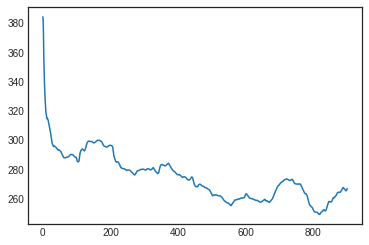

kic:h thangtaoDw
Sryvpite wy kaec
COyS?
Yalp t, tean.
BiclOlsdd wSyK, aAnchends rwrn OuanO

halnn?arac, Shefelyc
.Ox
K:oyrd ihd mee:.AB,huud ci, Iea B
R
RGNNK: bou dkserbC
:lensoches, Arouty hre
le UN


In [31]:
layers1 = [LSTMLayer(hidden_size = 256, output_size = 62, weight_scale= 0.01)]
mod = RNNModel(layers = layers1,
               vocab_size = 62, sequence_length = 25, 
               loss = SoftmaxCrossEntropy())
optim = AdaGrad(lr = 0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size = 3)
trainer.train(1000, sample_every=100)

Three variants of multiple layers

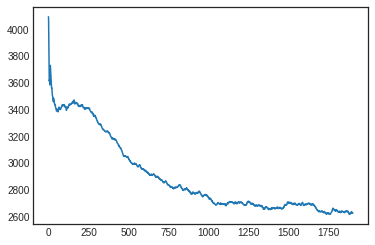

ase my op goPde un agty:
Wu yome  rilh,
rhe feifetfmos sotlwee, dou hon the thamss thod bus la monos thi ot hile andesKd,
Auld oir ou werome theas tos rit.

-U:RLUND:
var
Inesr! cey haed os un tow ar 


In [32]:
layers2 = [RNNLayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size = 62, weight_scale=0.01)]
mod = RNNModel(layers = layers2,
               vocab_size = 62, sequence_length = 25,
               loss = SoftmaxCrossEntropy())
optim = AdaGrad(lr = 0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size = 32)
trainer.train(2000, sample_every = 100)

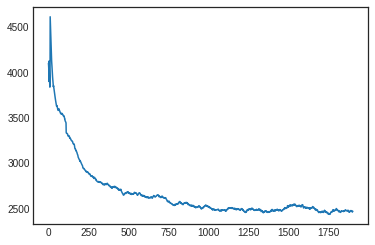

ill Porserd.
MANHLLE:
Lart, I I Zayse vilf Tart: ke a ERSS:
Bey, CVIOLIO:
I her herayo, jricVuld hent: I so, por it not not BellZrbe thine vord:l aln paa ghaent; I puld, jaee noz Lart here crirunnd J 


In [33]:
layers2 = [LSTMLayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers2,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = SGD(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)

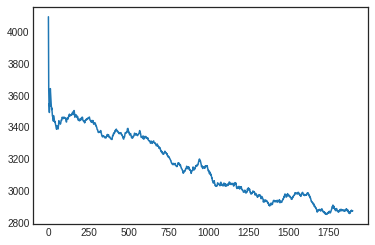

af dahC benond ganIn

aD bore mous  atercrisC tcesy
hal meou,Gkrd th arraYd and
rhaen
Oordt souchesc moouserd
, at outrwy ADOf,,our tee aos, aEl dofO wooas de tadt
Iehmasih dit fiu inHnt
 pud thanlthr


In [34]:
layers3 = [GRULayer(hidden_size=256, output_size=128, weight_scale=0.1),
           LSTMLayer(hidden_size=256, output_size=62, weight_scale=0.01)]
mod = RNNModel(layers=layers3,
               vocab_size=62, sequence_length=25,
               loss=SoftmaxCrossEntropy())
optim = AdaGrad(lr=0.01, gradient_clipping=True)
trainer = RNNTrainer('input.txt', mod, optim, batch_size=32)
trainer.train(2000, sample_every=100)